### TODO

1. Experiment with normalization
    - fit on train and just apply on test
    - try MinMax, 
    - try a different normalization model for each stock
2. Change predict length
    - try predicting a week in advance
3. Try trend classification
    - this would be an easier task than the regression on price

## Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from indicators import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Load data

In [2]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH',
'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI',
'UMC','ANET','EPAM',
'UI','XM',
'GIB','TRMB',
'TYL','WIX','HPE','LYFT',
'LOGI',
'MPWR']

In [3]:
top10tech = top100tech[:10]

In [4]:
def process_stock_data_from_yf(data):
    
    df = pd.melt(data, ignore_index=False)
    df.columns = ['Variable', 'Ticker', 'Value']
    # this is a nicely formed dataframe of historical data
    nice_df = df.reset_index().pivot(index=['Ticker', 'Date'], columns=['Variable'], values=['Value'])
    nice_df.columns = nice_df.columns.droplevel()
    df = nice_df.reset_index()
    df.columns.name=None
    return df
    
    

In [5]:
data = yf.download(tickers = ' '.join(top10tech),
                   auto_adjust=True,
                  period='4y')

[*********************100%***********************]  10 of 10 completed


In [6]:
nan_days = sum(data.isna().sum(axis=1)>0)
if nan_days >1:
    print("WARNING: there are {} days with missing data".format(nan_days))
data = data.dropna()

In [7]:
df = process_stock_data_from_yf(data)
df.head()

,Ticker,Date,Close,High,Low,Open,Volume
0,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0
1,AAPL,2017-03-20,33.588676,33.598173,33.296619,33.336984,86168000.0
2,AAPL,2017-03-21,33.204002,33.906835,33.177884,33.742999,158119600.0
3,AAPL,2017-03-22,33.579170,33.621912,33.185014,33.206387,103440800.0
4,AAPL,2017-03-23,33.460449,33.617162,33.386843,33.541179,81385200.0


### Parameters

In [8]:
trail_size=14

### Compute Technical Markers

In [9]:
# compute all our technical markers for each of the stocks. 
dataset = df.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Filter to only one stock

In [10]:
dataset = dataset.loc[dataset['Ticker']=='MSFT']

In [11]:
dataset

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
6036,MSFT,2017-03-17,61.048401,61.396599,60.869592,61.086045,49219700.0,61.396599,60.869592,4.921970e+07,61.048401,NaN,-66.070845,0.527007,0.000000,0.000000,61.048401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
6037,MSFT,2017-03-20,61.104862,61.340134,60.907235,61.086044,14598100.0,61.396599,60.869592,3.190890e+07,61.076632,0.039924,-54.347934,0.479953,-0.056465,0.037643,61.078648,NaN,61.156480,60.996783,1531.815082,1527.815082,NaN,NaN,499.987791,-11.764615,7.842997,499.987791,0.092486,0.001008,52.380230
6038,MSFT,2017-03-21,60.427280,61.641285,60.351992,61.349550,26640500.0,61.641285,60.351992,3.015277e+07,60.860181,0.375964,-94.160462,0.749733,0.301151,-0.555243,60.829823,NaN,61.612110,60.108252,163.877492,159.877492,NaN,NaN,337.040910,40.167732,-74.058702,418.514351,-1.017423,-0.015368,16.131225
6039,MSFT,2017-03-22,61.198975,61.302495,60.342588,60.342588,20680000.0,61.641285,60.342588,2.778458e+07,60.944880,0.350611,-10.784409,0.802277,-0.338790,-0.009404,60.942757,NaN,61.646102,60.243657,175.824767,171.824767,NaN,NaN,94.598588,-42.228604,-1.172126,310.542430,0.246646,-0.000573,-15.507925
6040,MSFT,2017-03-23,61.048401,61.396599,60.954286,61.114277,19269200.0,61.641285,60.342588,2.608150e+07,60.965584,0.307147,-78.722161,0.730284,0.094104,0.611698,60.970319,NaN,61.579878,60.351289,200.489793,196.489793,NaN,NaN,73.334165,12.885953,83.761707,251.240364,0.000000,0.002870,30.366740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,MSFT,2021-03-10,232.419998,237.000000,232.039993,237.000000,29733000.0,243.860001,224.259995,3.300931e+07,232.497143,3.929814,-92.338622,6.244287,1.619995,0.369995,232.828375,233.552287,240.356772,224.637514,61.162372,57.162372,237.996136,49.200987,62.814379,25.943638,5.925338,61.937915,-4.663848,-0.163680,22.877567
7038,MSFT,2021-03-11,237.130005,239.169998,234.309998,234.960007,29896000.0,239.169998,224.259995,3.334027e+07,232.222858,3.389867,-41.975165,6.463572,2.169998,2.270004,233.401926,232.386001,239.002592,225.443124,70.505008,66.505008,237.280229,54.475552,2.252388,33.572740,35.119967,56.289125,-1.593558,0.124494,59.224089
7039,MSFT,2021-03-12,235.750000,235.820007,233.229996,234.009995,22647900.0,239.169998,224.259995,3.235463e+07,232.311430,3.469488,-2.702973,6.130001,-3.349991,-1.080002,233.715002,232.092859,239.250405,225.372454,68.958426,64.958426,236.594063,52.747422,51.241372,-54.649112,-17.618299,58.985386,0.528764,0.267049,28.356052
7040,MSFT,2021-03-15,234.809998,235.190002,231.809998,234.960007,26034900.0,239.169998,224.259995,3.205507e+07,232.421429,3.526167,-11.242732,5.975715,-0.630005,-1.419998,233.861002,231.979716,239.473762,225.369096,67.913345,63.913345,235.944783,51.547871,38.536200,-10.542754,-23.762818,61.136570,0.660176,0.319114,13.594502


### Quick visualizations

<AxesSubplot:xlabel='Date'>

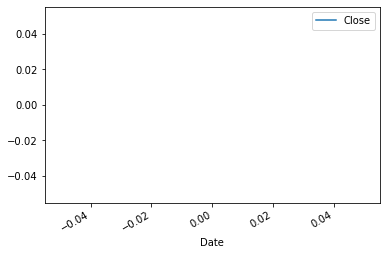

In [12]:
dataset.loc[dataset['Ticker']=='TSM', ['Date', 'Close']].set_index('Date').plot()

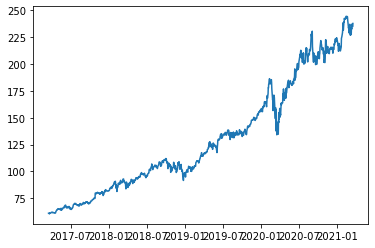

In [13]:
plt.plot('Date', 'Close', data=dataset)

In [14]:
dataset.shape

(1006, 31)

In [15]:
dataset.head(6)

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
6036,MSFT,2017-03-17,61.048401,61.396599,60.869592,61.086045,49219700.0,61.396599,60.869592,4.921970e+07,61.048401,NaN,-66.070845,0.527007,0.000000,0.000000,61.048401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
6037,MSFT,2017-03-20,61.104862,61.340134,60.907235,61.086044,14598100.0,61.396599,60.869592,3.190890e+07,61.076632,0.039924,-54.347934,0.479953,-0.056465,0.037643,61.078648,NaN,61.156480,60.996783,1531.815082,1527.815082,NaN,NaN,499.987791,-11.764615,7.842997,499.987791,0.092486,0.001008,52.380230
6038,MSFT,2017-03-21,60.427280,61.641285,60.351992,61.349550,26640500.0,61.641285,60.351992,3.015277e+07,60.860181,0.375964,-94.160462,0.749733,0.301151,-0.555243,60.829823,NaN,61.612110,60.108252,163.877492,159.877492,NaN,NaN,337.040910,40.167732,-74.058702,418.514351,-1.017423,-0.015368,16.131225
6039,MSFT,2017-03-22,61.198975,61.302495,60.342588,60.342588,20680000.0,61.641285,60.342588,2.778458e+07,60.944880,0.350611,-10.784409,0.802277,-0.338790,-0.009404,60.942757,NaN,61.646102,60.243657,175.824767,171.824767,NaN,NaN,94.598588,-42.228604,-1.172126,310.542430,0.246646,-0.000573,-15.507925
6040,MSFT,2017-03-23,61.048401,61.396599,60.954286,61.114277,19269200.0,61.641285,60.342588,2.608150e+07,60.965584,0.307147,-78.722161,0.730284,0.094104,0.611698,60.970319,NaN,61.579878,60.351289,200.489793,196.489793,NaN,NaN,73.334165,12.885953,83.761707,251.240364,0.000000,0.002870,30.366740
6041,MSFT,2017-03-24,61.151939,61.594245,60.944899,61.509550,22617100.0,61.641285,60.342588,2.550410e+07,60.996643,0.285061,-68.115525,0.716794,0.197646,-0.009388,61.012343,NaN,61.566764,60.426522,215.977754,211.977754,NaN,NaN,109.973043,27.573603,-1.309657,222.986899,0.169601,0.008403,42.552938


In [16]:
dataset.describe()

,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
count,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03,1006.000000,1006.000000,1.006000e+03,1006.000000,1005.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,993.000000,1005.000000,1005.000000,1005.000000,1005.000000,993.000000,992.000000,1.005000e+03,1006.000000,1006.000000,1005.000000,1006.000000,1006.000000,1005.000000
mean,130.020301,131.295253,128.609311,129.993737,2.943583e+07,134.203014,122.994297,2.943368e+07,128.904616,2.756184,-44.559809,2.925243,0.177588,0.174026,128.901394,129.419418,134.484503,123.459767,69.677313,65.677313,128.663244,58.075838,2.083838e+03,9.121478,8.376296,2085.310702,1.997864,1.192499,19.839913
std,51.603311,52.265859,50.902231,51.580798,1.358272e+07,54.113707,48.177634,1.028114e+07,51.099060,2.238756,30.217200,2.150482,2.135783,2.240796,51.042662,50.728209,54.193912,48.180535,59.227823,59.227823,50.388896,9.990187,4.397515e+04,63.148840,66.888726,11593.933754,4.866258,1.780852,47.599614
min,60.427280,61.302495,60.342588,60.342588,7.425600e+06,61.396599,60.342588,1.471908e+07,60.860181,0.039924,-100.000000,0.479953,-12.433658,-13.878958,60.829823,61.197185,61.156480,59.826295,14.480741,10.480741,61.122512,29.476141,1.776615e-06,-186.086578,-273.239258,26.638691,-22.134492,-7.772437,-138.307431
25%,89.471741,90.367699,88.607039,89.517912,2.074162e+07,92.082709,83.740492,2.301149e+07,88.295822,1.302361,-70.839305,1.413191,-0.531679,-0.609679,88.574179,89.302447,92.659394,84.329648,42.039541,38.039541,88.657100,51.292837,1.538510e+01,-26.454364,-28.193717,57.913533,-0.345941,0.327022,-15.752744
50%,114.164040,114.891919,113.123522,113.690198,2.599730e+07,115.312043,106.299095,2.683853e+07,110.621554,1.978183,-42.080189,2.221817,0.147203,0.195403,110.886700,112.310610,115.399265,107.634418,60.811741,56.811741,110.750784,57.533427,4.000135e+01,6.816818,9.681825,80.850128,2.085237,0.971730,28.665757
75%,167.638668,171.432887,164.236011,167.737933,3.361525e+07,178.189224,154.454269,3.341358e+07,165.258492,3.437157,-16.666485,4.044776,0.956705,0.953925,165.622124,165.539513,178.984782,154.335757,83.177341,79.177341,164.218401,65.134963,8.477833e+01,43.423839,47.255734,127.528269,4.881699,2.021516,57.854200
max,244.427048,245.564423,242.361793,244.466945,1.112421e+08,245.564423,232.399994,7.924272e+07,242.245561,12.154385,-0.000000,12.851547,12.448435,11.346555,240.478950,242.370644,250.154901,238.782029,1531.815082,1527.815082,240.130592,89.265598,1.095366e+06,582.690312,417.680997,78366.424518,21.716399,6.438317,162.709976


In [17]:
tickers = dataset['Ticker'].unique()

In [18]:
dataset.isna().sum()

Ticker       0
Date         0
Close        0
High         0
Low          0
Open         0
Volume       0
HH           0
LL           0
AV           0
SMA          0
SD           1
WILLR        0
ATR          0
DMH          0
DML          0
EMA          0
WMA         13
BBHIGH       1
BBLOW        1
PERBHIGH     1
PERBLOW      1
TRIMA       13
RSI         14
DX           1
PDI          0
NDI          0
ADX          1
ROC          0
MACD         0
CCI          1
dtype: int64

### Choose features

In [19]:
dataset.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
6036,MSFT,2017-03-17,61.048401,61.396599,60.869592,61.086045,49219700.0,61.396599,60.869592,4.921970e+07,61.048401,NaN,-66.070845,0.527007,0.000000,0.000000,61.048401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
6037,MSFT,2017-03-20,61.104862,61.340134,60.907235,61.086044,14598100.0,61.396599,60.869592,3.190890e+07,61.076632,0.039924,-54.347934,0.479953,-0.056465,0.037643,61.078648,NaN,61.156480,60.996783,1531.815082,1527.815082,NaN,NaN,499.987791,-11.764615,7.842997,499.987791,0.092486,0.001008,52.380230
6038,MSFT,2017-03-21,60.427280,61.641285,60.351992,61.349550,26640500.0,61.641285,60.351992,3.015277e+07,60.860181,0.375964,-94.160462,0.749733,0.301151,-0.555243,60.829823,NaN,61.612110,60.108252,163.877492,159.877492,NaN,NaN,337.040910,40.167732,-74.058702,418.514351,-1.017423,-0.015368,16.131225
6039,MSFT,2017-03-22,61.198975,61.302495,60.342588,60.342588,20680000.0,61.641285,60.342588,2.778458e+07,60.944880,0.350611,-10.784409,0.802277,-0.338790,-0.009404,60.942757,NaN,61.646102,60.243657,175.824767,171.824767,NaN,NaN,94.598588,-42.228604,-1.172126,310.542430,0.246646,-0.000573,-15.507925
6040,MSFT,2017-03-23,61.048401,61.396599,60.954286,61.114277,19269200.0,61.641285,60.342588,2.608150e+07,60.965584,0.307147,-78.722161,0.730284,0.094104,0.611698,60.970319,NaN,61.579878,60.351289,200.489793,196.489793,NaN,NaN,73.334165,12.885953,83.761707,251.240364,0.000000,0.002870,30.366740


In [20]:
dataset.columns.tolist()

['Ticker',
 'Date',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'HH',
 'LL',
 'AV',
 'SMA',
 'SD',
 'WILLR',
 'ATR',
 'DMH',
 'DML',
 'EMA',
 'WMA',
 'BBHIGH',
 'BBLOW',
 'PERBHIGH',
 'PERBLOW',
 'TRIMA',
 'RSI',
 'DX',
 'PDI',
 'NDI',
 'ADX',
 'ROC',
 'MACD',
 'CCI']

In [21]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume', ]
#  'HH', 'LL', 'AV',
#  'SMA', 'SD', 'WILLR',
#  'ATR', 'DMH', 'DML',
#  'EMA', 'WMA', 'BBHIGH',
#  'BBLOW', 'PERBHIGH', 'PERBLOW',
#  'TRIMA', 'RSI', 'DX',
#  'PDI', 'NDI', 'ADX',
#  'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

In [22]:
# simple one normalizing model approach

sc = RobustScaler()
dataset[features] = sc.fit_transform(dataset[features])

<ipython-input-22-127d150588a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[features] = sc.fit_transform(dataset[features])
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [23]:
dataset.describe()

,Close,High,Low,Open,Volume
count,1006.000000,1.006000e+03,1006.000000,1006.000000,1006.000000
mean,0.202851,2.023474e-01,0.204760,0.208432,0.267099
std,0.660168,6.447386e-01,0.673052,0.659432,1.055081
min,-0.687462,-6.610658e-01,-0.697893,-0.682020,-1.442616
25%,-0.315892,-3.025247e-01,-0.324168,-0.309029,-0.408251
50%,0.000000,8.765775e-17,0.000000,0.000000,0.000000
75%,0.684108,6.974753e-01,0.675832,0.690971,0.591749
max,1.666472,1.611944e+00,1.708846,1.671909,6.621663


### Train test split

In [24]:
train = dataset.loc[dataset['Date'] < "2020-03-13"]
test = dataset.loc[dataset['Date'] > "2020-03-13"]

In [25]:
train.head()

,Ticker,Date,Close,High,Low,Open,Volume
6036,MSFT,2017-03-17,-0.679516,-0.659905,-0.690925,-0.672515,1.803874
6037,MSFT,2017-03-20,-0.678793,-0.660601,-0.690427,-0.672515,-0.885469
6038,MSFT,2017-03-21,-0.687462,-0.656887,-0.697769,-0.669146,0.049963
6039,MSFT,2017-03-22,-0.677589,-0.661066,-0.697893,-0.682020,-0.413038
6040,MSFT,2017-03-23,-0.679516,-0.659905,-0.689805,-0.672154,-0.522627


In [26]:
test.head()

,Ticker,Date,Close,High,Low,Open,Volume
6789,MSFT,2020-03-16,0.254502,0.406533,0.271303,0.318351,4.808949
6790,MSFT,2020-03-17,0.395711,0.383941,0.271304,0.318351,4.277156
6791,MSFT,2020-03-18,0.317571,0.365624,0.271565,0.293039,4.318589
6792,MSFT,2020-03-19,0.346826,0.416302,0.323661,0.353408,4.654897
6793,MSFT,2020-03-20,0.278945,0.379057,0.282560,0.394286,4.572830


<AxesSubplot:xlabel='Date'>

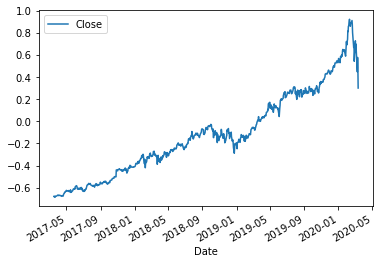

In [27]:
train.loc[dataset['Ticker']=='MSFT', ['Date', 'Close']].set_index('Date').plot()

<AxesSubplot:xlabel='Date'>

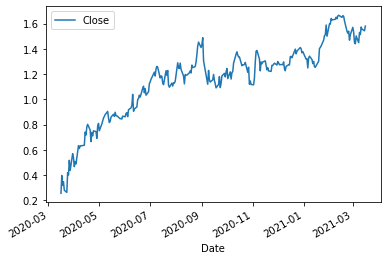

In [28]:
test.loc[dataset['Ticker']=='MSFT', ['Date', 'Close']].set_index('Date').plot()

### Convert one stock into x and y format for input to model

In [29]:
predict_length = 1
def apply_rolling(stock, trail_size):
    x = []
    y = []
    for i in range(trail_size, len(stock) + 1 - predict_length):
        x_point = stock.drop(columns=['Date', 'Ticker']).iloc[i-trail_size : i].values
        y_point = stock['Close'].iloc[i + predict_length -1]
        
        if np.isnan(x_point).sum() ==0:
            x.append(x_point)
            y.append(y_point)
    
    return np.array(x), np.array(y)

In [30]:
x, y = apply_rolling(dataset.loc[dataset['Ticker']=='AAPL'], trail_size=3)

In [31]:
dataset.loc[dataset['Ticker']=='AAPL']

,Ticker,Date,Close,High,Low,Open,Volume


In [32]:
x.shape

(0,)

In [33]:
y.shape

(0,)

### Convert all stocks into x and y for model input

In [34]:
def roll_all_stocks(dataset, trail_size):
    res = dataset.groupby('Ticker').apply(lambda x: apply_rolling(x, trail_size=trail_size))
    x = [x[0] for x in res.values]
    y = [x[1] for x in res.values]
    return np.concatenate(x), np.concatenate(y)

In [35]:
x_train, y_train = roll_all_stocks(train, trail_size)

In [36]:
x_train.shape

(738, 14, 5)

In [37]:
y_train.shape

(738,)

In [38]:
x_test, y_test = roll_all_stocks(test, trail_size)

In [39]:
x_test.shape

(239, 14, 5)

In [40]:
y_test.shape

(239,)

In [41]:
np.isnan(x_train).sum() == 0 and np.isnan(x_test).sum() and np.isnan(y_test).sum() and np.isnan(y_train).sum()

0

### Model Design

In [42]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [43]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [44]:
# model = Sequential()
# model.add(Dense(100, input_shape=(trail_size, num_features), activation='relu'))
# model.add(Dropout(0.1))

# model.add(Flatten())

# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.1))

# # model.add(Dense(50, activation='relu'))
# # model.add(Dense(25, activation='relu'))
# model.add(Dense(1, activation='linear'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 14, 75)            24300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 75)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 420)              

In [46]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
history = model.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test), batch_size=32, shuffle=False)

Epoch 1/80
24/24 [==============================] - 6s 60ms/step - loss: 0.0977 - val_loss: 0.2329
Epoch 2/80
24/24 [==============================] - 0s 10ms/step - loss: 0.0106 - val_loss: 0.1997
Epoch 3/80
24/24 [==============================] - 0s 10ms/step - loss: 0.0280 - val_loss: 0.2737
Epoch 4/80
24/24 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.1495
Epoch 5/80
24/24 [==============================] - 0s 11ms/step - loss: 0.0188 - val_loss: 0.1495
Epoch 6/80
24/24 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.1413
Epoch 7/80
24/24 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.1204
Epoch 8/80
24/24 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.1009
Epoch 9/80
24/24 [==============================] - 0s 10ms/step - loss: 0.0117 - val_loss: 0.0875
Epoch 10/80
24/24 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0909
Epoch 11/

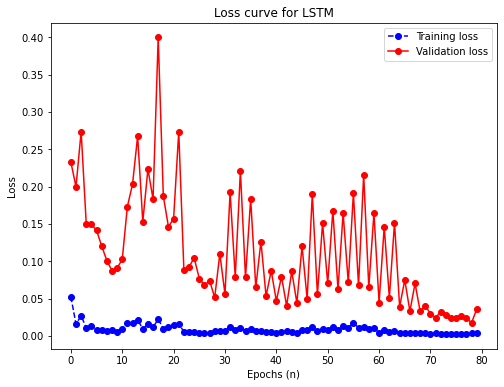

In [48]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.title("Loss curve for LSTM")
plt.show()

In [49]:
def evaluate_model_rmse(y_preds, y_true):
    dummies = np.zeros((y_preds.shape[0], num_features-1))
    res = np.concatenate([y_preds, dummies], axis=1)
    pred_dollars = sc.inverse_transform(res)[:, 0]
    
    res2 = np.concatenate([np.expand_dims(y_true, axis=1), dummies], axis=1)
    true_dollars = sc.inverse_transform(res2)[:, 0]
    return np.sqrt(mean_squared_error(true_dollars, pred_dollars))

In [50]:
model.predict(x_train).shape

(738, 1)

In [51]:
np.zeros((y_train.shape[0], num_features-1)).shape

(738, 4)

In [52]:
model.predict(x_train).shape

(738, 1)

In [53]:
y_train.shape

(738,)

In [54]:
x_train.shape

(738, 14, 5)

In [55]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), y_train)))

Training RMSE = 3.3099678943834223


In [56]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), y_test)))

Testing RMSE = 14.76722538457393


#### Compare to simple baseline

In [57]:
def predict_no_change(x):
    return x[-1][0]

In [58]:
no_change_preds = np.array([predict_no_change(x) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [59]:
evaluate_model_rmse(no_change_preds, y_train)

1.897278284769269

In [60]:
no_change_preds = np.array([predict_no_change(x) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [61]:
evaluate_model_rmse(no_change_preds, y_test)

3.873167416346691